## Visualization with *yt* and Napari Part 2: annotations

In this notebook series, we'll continue our exploration of using [napari](https://napari.org/) to interactively visualize data loaded and sampled with [*yt*](yt-project.org/). The first notebook in this series [fixThislink](https://doesnoteexist.com) covered loading both in-memory and dask lazy-loaded *yt* arrays extracted from Fixed Resolution Regions into napari. In this notebook, we'll explore ways to use napari's point and shape layers to add annotations including: [Particle Positions](#Particle-Positions), [3D Streamlines](#3D-Streamlines) and [Vector Fields](#Vector-Fields).


## required packages

Running this notebook requires *yt* and napari in addition to stanard packages from the scipy stack (numpy, matplotlib). 


## imports 

So let's start off by setting up the `qt` environment needed by napari:

In [1]:
 # for napari, do it first!
%gui qt

and import all the packages we'll use

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt 
import os

# yt related
import yt
from yt.units import kpc, Mpc

# napari related imports 
import napari
from napari.utils import nbscreenshot

## Test data 

In this notebook, we'll use the `Enzo_64` test dataset (download [here](http://yt-project.org/data/Enzo_64.tar.gz), 2.4 Gb). So let's load and slice it, centered on the location of the max density:

yt : [INFO     ] 2020-09-08 15:32:00,481 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2020-09-08 15:32:00,481 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2020-09-08 15:32:00,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-09-08 15:32:00,482 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-09-08 15:32:00,483 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-09-08 15:32:00,483 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2020-09-08 15:32:00,483 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2020-09-08 15:32:00,484 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2020-09-08 15:32:00,484 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-09-08 15:32:00,484 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 752/752 [00:00<00:00, 8463.20it/s]
yt : [INFO     ] 2020-09-08 15:


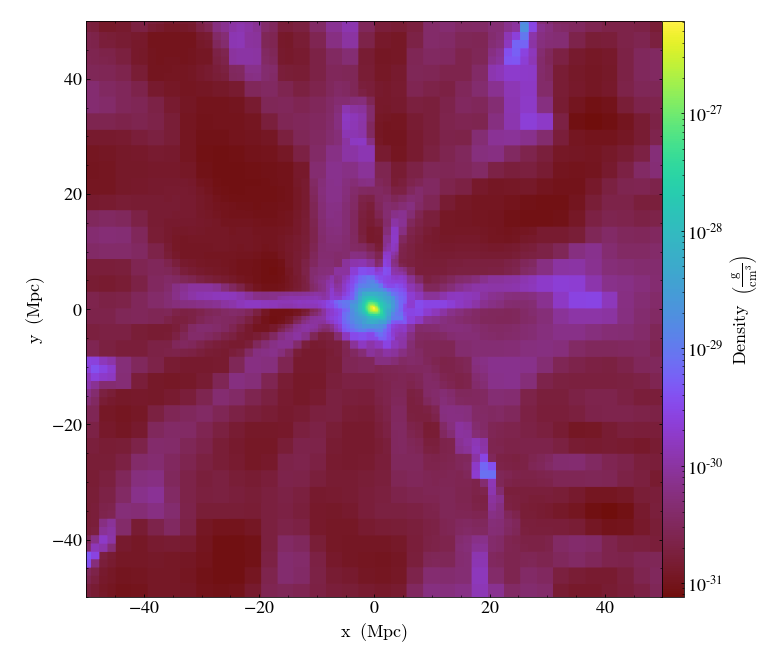

In [3]:
ds = yt.load("Enzo_64/DD0043/data0043")
slc = yt.SlicePlot(ds, 'z', 'density', center='m',width=(100,'Mpc'))
slc.show()

In [29]:
slc.center

[unyt_quantity(0.20263672, 'code_length'),
 unyt_quantity(0.54638672, 'code_length')]

## Particle Positions

In *yt*, we we can add particle positions to the slice following the example in the *yt* docs ([link](https://yt-project.org/doc/visualizing/callbacks.html#overplotting-particle-positions)):


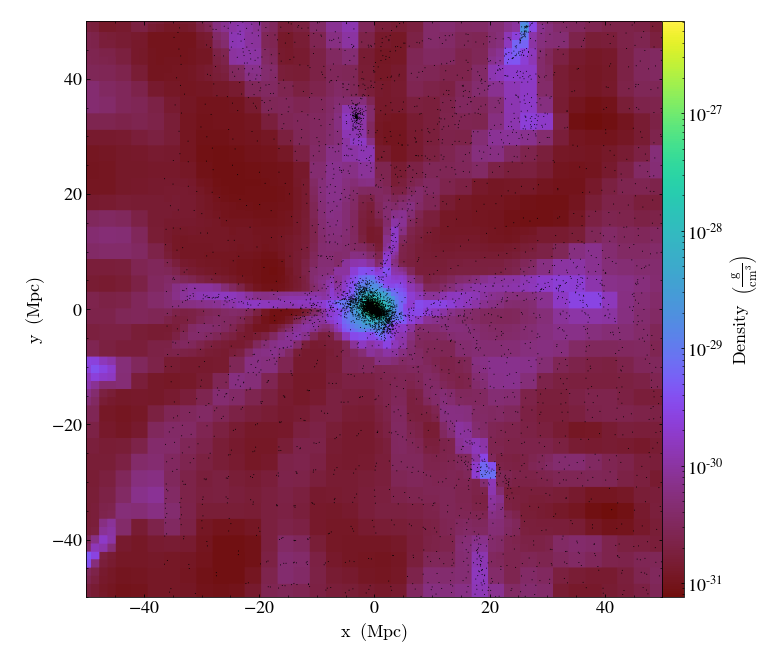

In [4]:
slc.annotate_particles((10, 'Mpc'))
slc.show()

But for napari, we'll need to extract that particle position data. 

Let's start, by following the [previous notebook and pull](LINK) out a Fixed Resolution Region of the log of the density field into memory and adding it to a napari viewer:

In [4]:
cg = ds.r[::300j,::300j,::300j]
dens_log = np.log10(cg['density'])

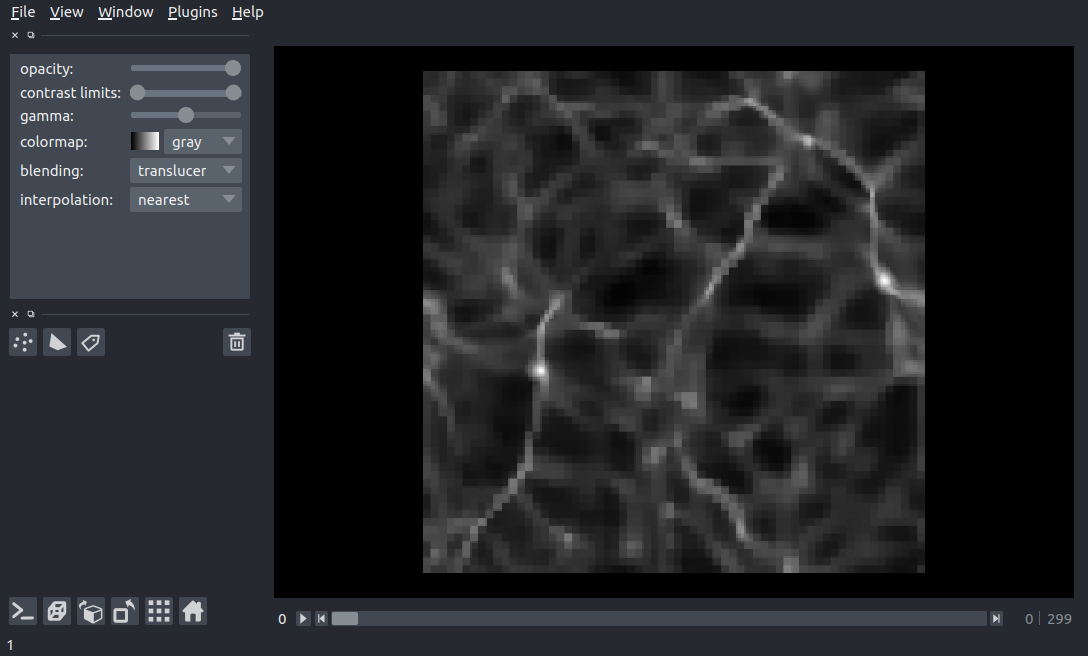

In [262]:
viewer = napari.Viewer()
viewer.add_image(dens_log)
nbscreenshot(viewer)

Now the question is how do we add our particle positions? 

From the napari docs, we have the following example ([link](https://napari.org/tutorials/fundamentals/points.html)) for adding points to an image:

```
from skimage import data
import napari

viewer = napari.view_image(data.astronaut(), rgb=True)
points = np.array([[100, 100], [200, 200], [300, 100]])
viewer.add_points(points, size=30)
```

where `points` is an array with shape `(N, D)` for `N` points in `D` dimensions. 

So all we need to do is extract some particle positions and reshape it to an array of the right dimensions. 

So let's do just that! Easy enough in *yt*: 

In [7]:
ad = ds.all_data()
particles = np.column_stack((ad['particle_position_x'],ad['particle_position_y'],ad['particle_position_z']))
particles.shape

(274305, 3)

Great! We now have our N by D array to add to napari! but wait... these positions are in the `code_length` of the data set:

In [8]:
ad['particle_position_x'][0]

unyt_quantity(0.01247314, 'code_length')

but our image's coordinate system is in pixel values so we need to convert our to a pixel coordinate system. Our domain in `code_length` goes from 0 to 1 in each dimension

In [9]:
print(ds.domain_left_edge)
print(ds.domain_right_edge)

[0. 0. 0.] code_length
[1. 1. 1.] code_length


and we pulled out a 300-pixel image, so we can just multiply the positions by 300: 

In [10]:
particles  = particles * 300 

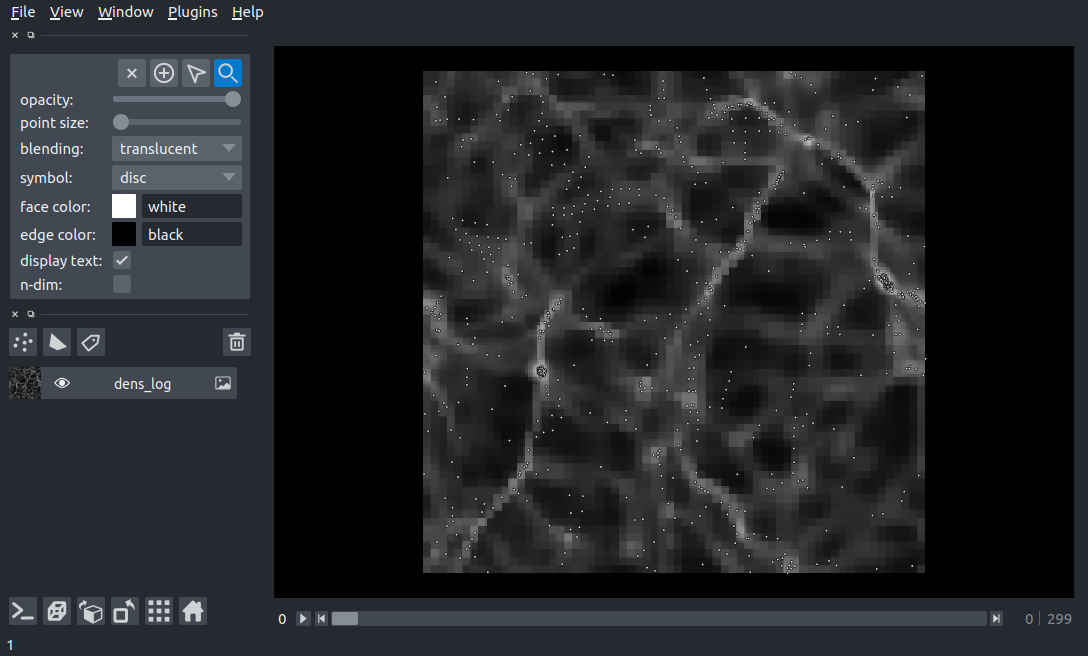

In [11]:
viewer.add_points(particles, size=1)
nbscreenshot(viewer)

Now when we slide through the domain, we also slice through the particle positions: 

<video controls src="resources/napari_5.mp4" />

In [ ]:
slc.center

## 3D Streamlines

Napari also has a `path` shape type that we can use to add 3D streamlines. So let's first calculate some streamlines. Following [*yt*'s example streamline notebook](https://yt-project.org/doc/visualizing/streamlines.html), we first define our streamline starting positions as random position within a range of the domain center:

In [12]:
N = 30
c = ds.domain_center
scale = ds.domain_width[0]*.25
pos_dx = np.random.random((N,3))*scale - scale/2
pos = c+pos_dx

Now we create and integrate our streamline object (this step can take a few minutes):

In [13]:
# Create streamlines of the 3D vector velocity and integrate them through
# the box defined above
streamlines = yt.visualization.api.Streamlines(ds, pos, 'velocity_x', 'velocity_y', 'velocity_z',
                          length=30.0*Mpc, get_magnitude=True)
streamlines.integrate_through_volume()


yt : [INFO     ] 2020-09-08 14:49:17,039 AMRKDTree rebuilt, Final Volume: 1.000000e+00
Streamlining: 100%|██████████| 30/30 [00:00<00:00, 130.01it/s]


The `streamlines` object now has a list of streamlines in `streamlines.streamlines`. To access the first 5 positions of the the first streamline:

In [14]:
streamlines.streamlines[0][:5]

unyt_array([[0.46162683, 0.48992705, 0.54153377],
            [0.46072062, 0.48956872, 0.54152966],
            [0.45981569, 0.48920725, 0.54152118],
            [0.45891209, 0.48884258, 0.54150841],
            [0.45800989, 0.48847465, 0.54149145]], 'code_length')

To add to napari, we can use the `viewer.add_shapes` with a `shape_type` of `line`, but first we once again need to convert to pixel coordinates

In [15]:
streamlines.streamlines = streamlines.streamlines * 300 

and then add to the viewer with `add_shapes` (we'll also switch to a 3D view): 

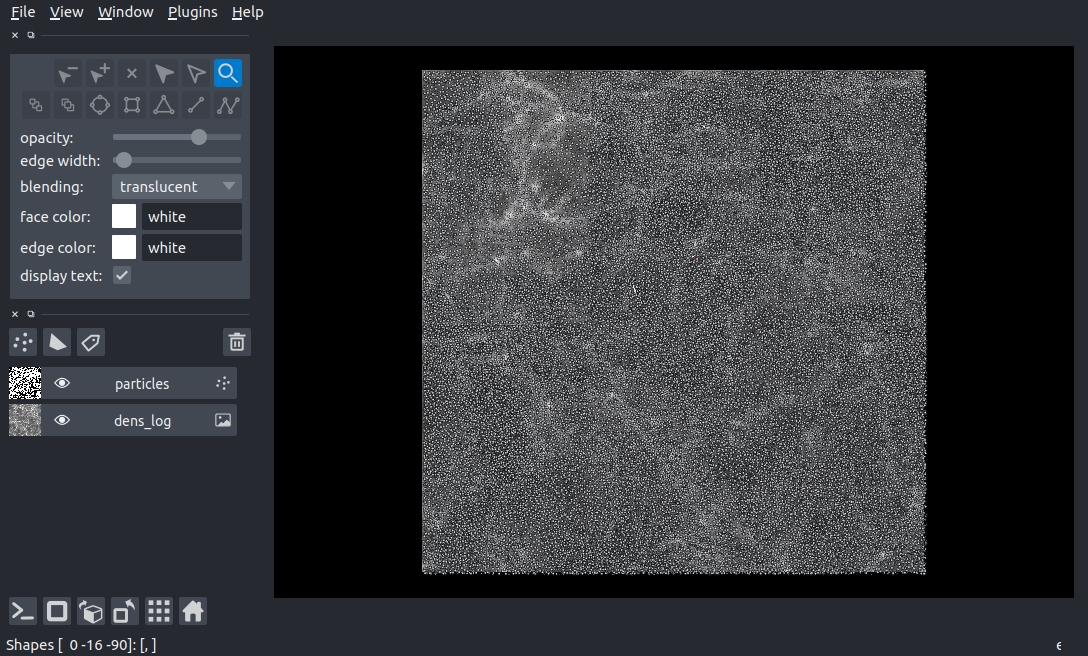

In [16]:
viewer.add_shapes(streamlines.streamlines, shape_type='path', edge_width=1, edge_color=['white'])
viewer.dims.ndisplay = 3
nbscreenshot(viewer)

Let's turn off the particles and check out those streamlines:


<video controls src="resources/napari_6.mp4" />

## Vector Fields

Napari also has a [vectors layer](https://napari.org/tutorials/fundamentals/vectors.html) so let's try adding a vector field!

First, for reference first we'll add an arbitrary single vector. `veiwer.add_vector()` expects a `vector` array as follows:

```
vectors : (N, 2, D) or (N1, N2, ..., ND, D) array
    An (N, 2, D) array is interpreted as "coordinate-like" data and a
    list of N vectors with start point and projections of the vector in
    D dimensions. An (N1, N2, ..., ND, D) array is interpreted as
    "image-like" data where there is a length D vector of the
    projections at each pixel.
```    

So a vectors array with a single vector starting at pixel `(1,1,1)`and ending at `(100,100,200)` would look like:

In [12]:
vectors = np.array([[
    [1,1,1],
    [100,100,200]    
]])

vectors.shape

(1, 2, 3)

and we add this to the napari viewer with

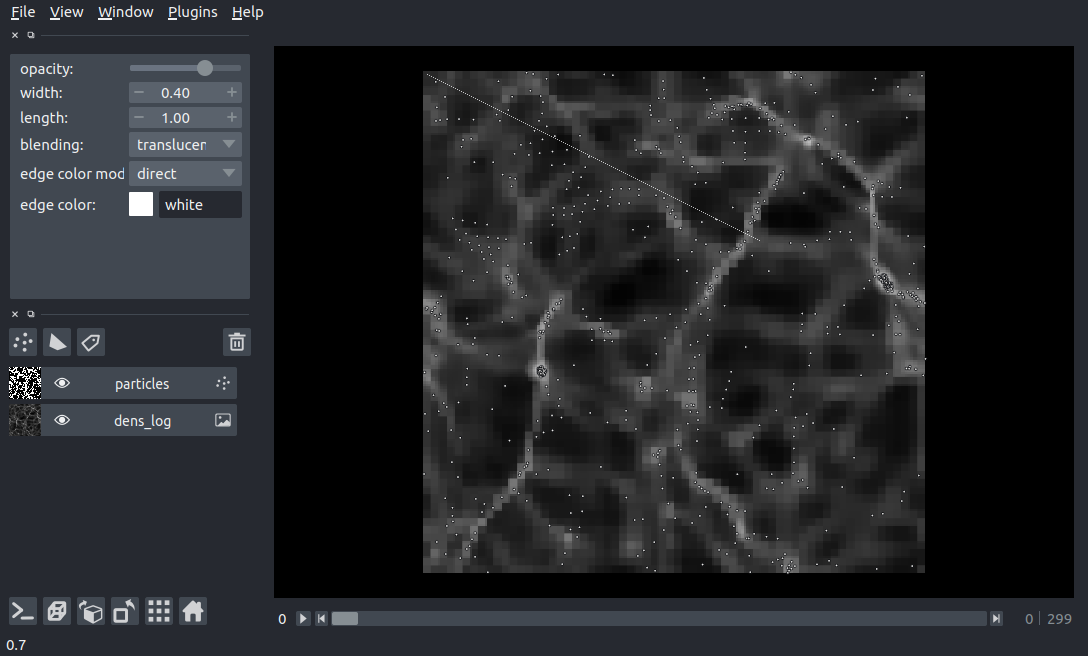

In [13]:
viewer.add_vectors(
        vectors, edge_width=0.4, name='sample vector', edge_color='white'
    )
nbscreenshot(viewer)

Rotating the image reveals a vector that goes from the corner inwards as expected: 

<video controls src="resources/napari_7.mp4" />

Ok, so now we'll assemble some velocity vectors to add. We'll do this in an explicit loop to make it clear how we're assembling (this loop could be improved with some smart numpy array manipulation). We'll also normalize each vector by the maximum velocity magnitude of the whole domain.

In [14]:
ad['x'].shape

(1070273,)

In [269]:
def sample_vectors(cg,xrange,yrange=None,zrange=None,pos_scale = 300):
    
    max_mag = np.max(np.sqrt(ad['x-velocity']**2+ad['y-velocity']**2+ad['z-velocity']**2)) 
    
    if yrange is None:
        yrange = xrange 
    if zrange is None:
        zrange = xrange 
        
    vx = cg['x-velocity'][xrange,yrange,zrange].ravel()
    vy = cg['y-velocity'][xrange,yrange,zrange].ravel()
    vz = cg['z-velocity'][xrange,yrange,zrange].ravel()
    v = np.column_stack((vx,vy,vz)) / max_mag 

    xr = [[cg[dim].min().to('code_length'),cg[dim].max().to('code_length')] for dim in ['x','y','z']]
    x = (cg['x'].to('code_length')[xrange,yrange,zrange].ravel() - xr[0][0])/(xr[0][1]-xr[0][0])
    y = (cg['y'].to('code_length')[xrange,yrange,zrange].ravel() - xr[1][0])/(xr[1][1]-xr[1][0])
    z = (cg['z'].to('code_length')[xrange,yrange,zrange].ravel() - xr[2][0])/(xr[2][1]-xr[2][0])
#     y = cg['y'].to('code_length')[xrange,yrange,zrange].ravel()
#     z = cg['z'].to('code_length')[xrange,yrange,zrange].ravel()
    p = np.column_stack((x.ravel(),y.ravel(),z.ravel())) * pos_scale

    return np.stack((p,v),axis=1)


def sample_particle_vectors(cg,pos_scale=300):
    max_mag = np.max(np.sqrt(cg['particle_velocity_x']**2 + cg['particle_velocity_y'] ** 2 + cg['particle_velocity_z']**2))
  
    vx = cg['particle_velocity_x']
    vy = cg['particle_velocity_y']
    vz = cg['particle_velocity_z']
    v = np.column_stack((vx,vy,vz)) / max_mag 

    xr = [[cg[dim].min().to('code_length'),cg[dim].max().to('code_length')] for dim in ['x','y','z']]
    x = (cg['particle_position_x'].to('code_length') - xr[0][0])/(xr[0][1]-xr[0][0])
    y = (cg['particle_position_y'].to('code_length') - xr[1][0])/(xr[1][1]-xr[1][0])
    z = (cg['particle_position_z'].to('code_length') - xr[2][0])/(xr[2][1]-xr[2][0])
    p = np.column_stack((x,y,z)) * pos_scale

    return np.stack((p,v),axis=1)

Let's first add a vector stack that will give us a regular grid of vectors in every dimension:

In [26]:
step = 10
vectors_subset = sample_vectors(cg,slice(0,300,step))
vectors_subset.shape

(27000, 2, 3)

In [270]:
particle_vecs = sample_particle_vectors(cg)
particle_vecs.shape

(274305, 2, 3)

In [279]:
particle_vecs_sample = particle_vecs[np.random.choice(particle_vecs.shape[0],20000,replace=False)]
particle_vecs_sample.shape

(20000, 2, 3)

Now we add a new vector layer and scale the vector length: 

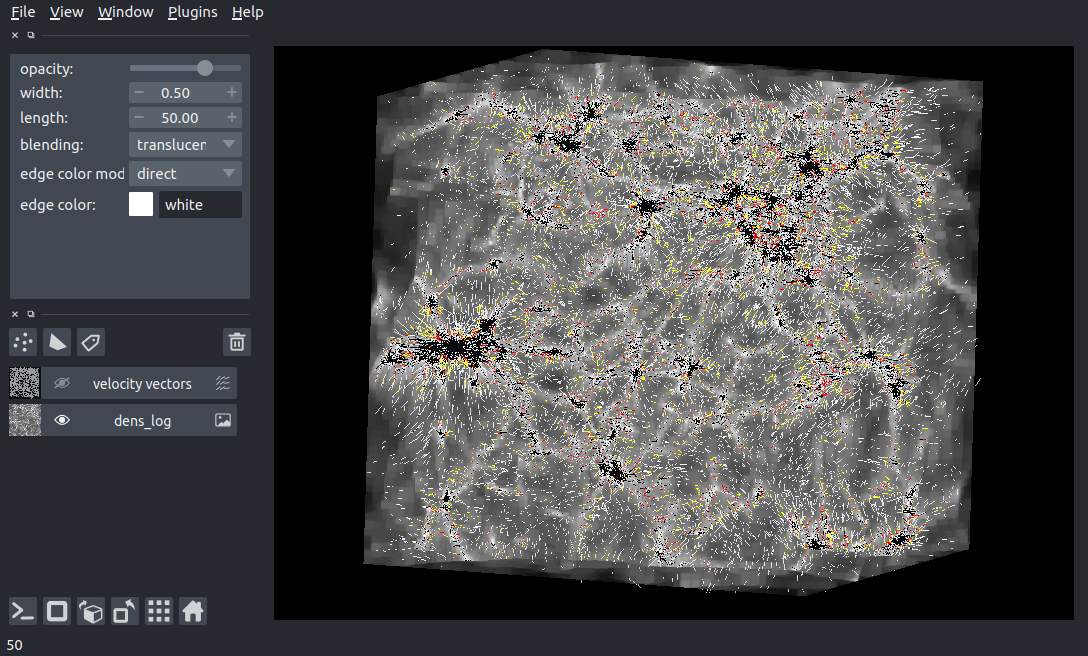

In [280]:
viewer.add_vectors(
        particle_vecs_sample, edge_width=0.5, name='velocity vectors', edge_color='white'
    )
viewer.active_layer.length=50
nbscreenshot(viewer)

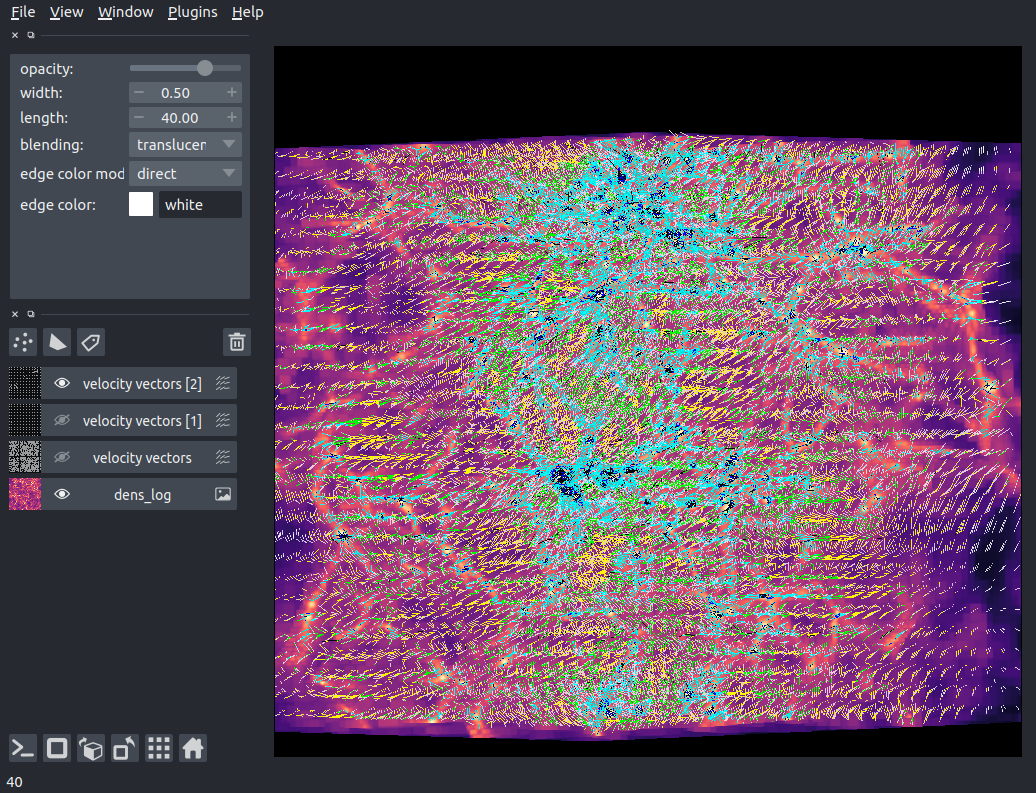

In [27]:
viewer.add_vectors(
        vectors_subset, edge_width=0.5, name='velocity vectors', edge_color='white'
    )
viewer.active_layer.length=40
nbscreenshot(viewer)

because we've only pulled out every 10 points, when we slice through the domain we don't always have vectors in the plane, but it does let us view in 3D without overwhelming the image:

In [ ]:
step = 10
vectors_subset = sample_vectors(cg,slice(0,300,1),slice(0,300,step),slice(0,300,step))
vectors_subset.shape

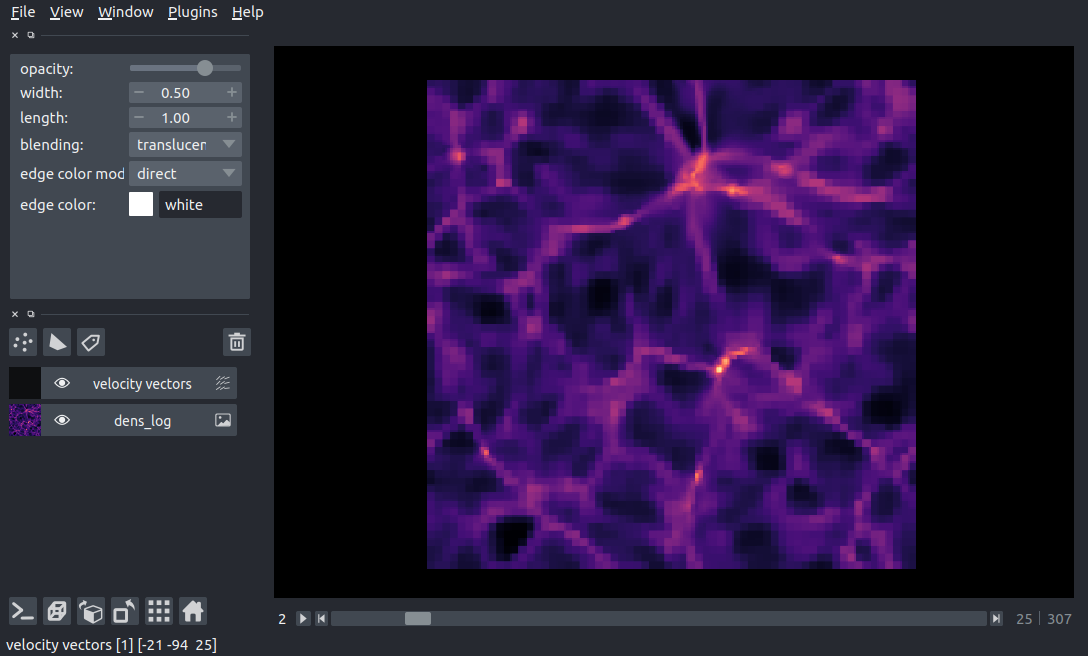

In [15]:
viewer.add_vectors(
        vectors_subset, edge_width=0.5, name='velocity vectors', edge_color='white'
    )
nbscreenshot(viewer)

<video controls src="resources/napari_8.mp4" />

In [235]:
x, y, z = ad.argmin("density")
c = [x.to('cm').to_value(),y.to('cm').to_value(),z.to('cm').to_value()]
c

# 6.27782e-27 at 
# 112568199846666733380173824.0000000000000000 
# 303527266574506220996001792.0000000000000000 
# 62658443770072329458024448.0000000000000000

[4.817376456088678e+26, 1.5189925762441777e+26, 2.7341866372395197e+26]

In [238]:
[np.log10(112568199846666733380173824.),np.log10(4.817376456088678e+26)]

[26.05141572105119, 26.682810585781677]

In [220]:
x.to_value()

4.817376456088678e+26

In [221]:
from unyt import Mpc

hwid = 30 
# c = [140,50,88]
region = ds.r[(c[0]-hwid,'Mpc'):(c[0]+hwid,'Mpc'):300j,
              (c[1]-hwid,'Mpc'):(c[1]+hwid,'Mpc'):300j,
              (c[2]-hwid,'Mpc'):(c[2]+hwid,'Mpc'):300j]
dens_2 = np.log10(region['density'])

In [222]:
dens_2.shape

(300, 300, 300)

In [223]:
[dens_2.max(),dens_2.min()]

[-26.938846147876887, -31.418821376075886]

In [256]:
try: 
    viewer.close()
except:
    pass
viewer = napari.Viewer()
viewer.add_image(dens_2)

<Image layer 'dens_2' at 0x7f91d86c1c90>

In [233]:
vectors_subset = sample_vectors(region,slice(0,300,1),slice(0,300,15),slice(0,300,15))
vectors_subset.shape

(120000, 2, 3)

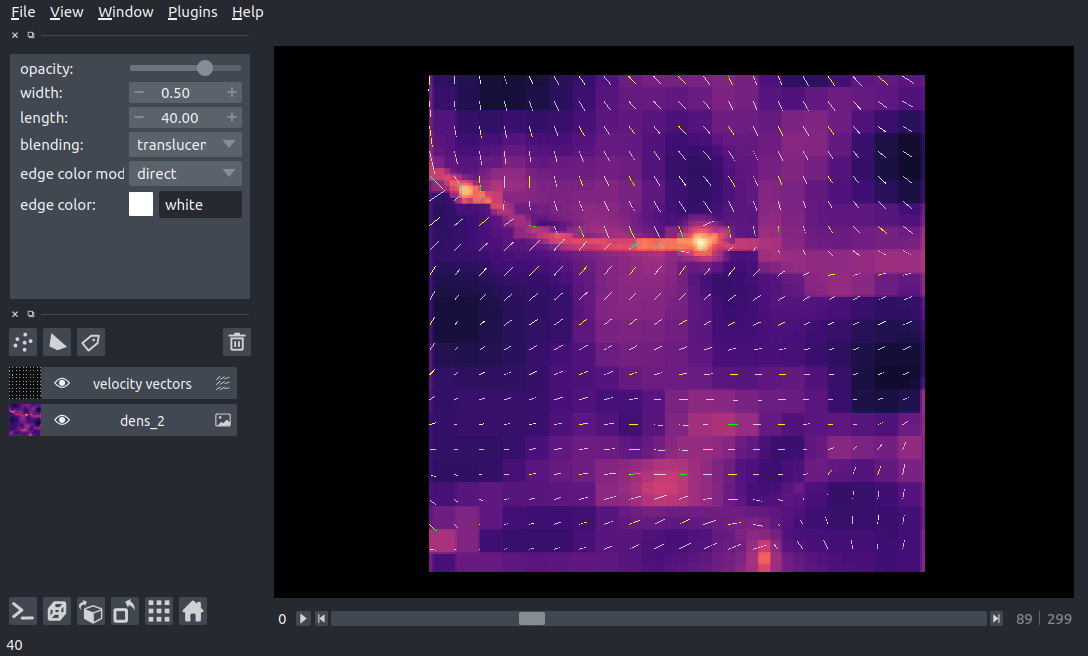

In [234]:
viewer.add_vectors(
        vectors_subset, edge_width=0.5, name='velocity vectors', edge_color='white'
    )
viewer.active_layer.length=40
nbscreenshot(viewer)

In [48]:
slc.

'center-window'

In [50]:
ds.domain_right_edge.to('Mpc')

unyt_array([180.03089126, 180.03089126, 180.03089126], 'Mpc')

In [245]:
region['particle_velocity_x'].shape

(11660,)

In [253]:
max_mag = np.max(np.sqrt(ad['particle_velocity_x']**2 + ad['particle_velocity_y'] ** 2 + ad['particle_velocity_z']**2))

def return_particle_vectors(ad,pos_scale=300):
    ad['particle_position_x']
  
    vx = ad['particle_velocity_x']
    vy = ad['particle_velocity_y']
    vz = ad['particle_velocity_z']
    v = np.column_stack((vx,vy,vz)) / max_mag 

    xr = [[ad[dim].min().to('code_length'),ad[dim].max().to('code_length')] for dim in ['x','y','z']]
    x = (ad['particle_position_x'].to('code_length') - xr[0][0])/(xr[0][1]-xr[0][0])
    y = (ad['particle_position_x'].to('code_length') - xr[1][0])/(xr[1][1]-xr[1][0])
    z = (ad['particle_position_x'].to('code_length') - xr[2][0])/(xr[2][1]-xr[2][0])
    p = np.column_stack((x,y,z)) * pos_scale

    return np.stack((p,v),axis=1)

In [254]:
particle_vectors = return_particle_vectors(region)
particle_vectors.shape

(11660, 2, 3)

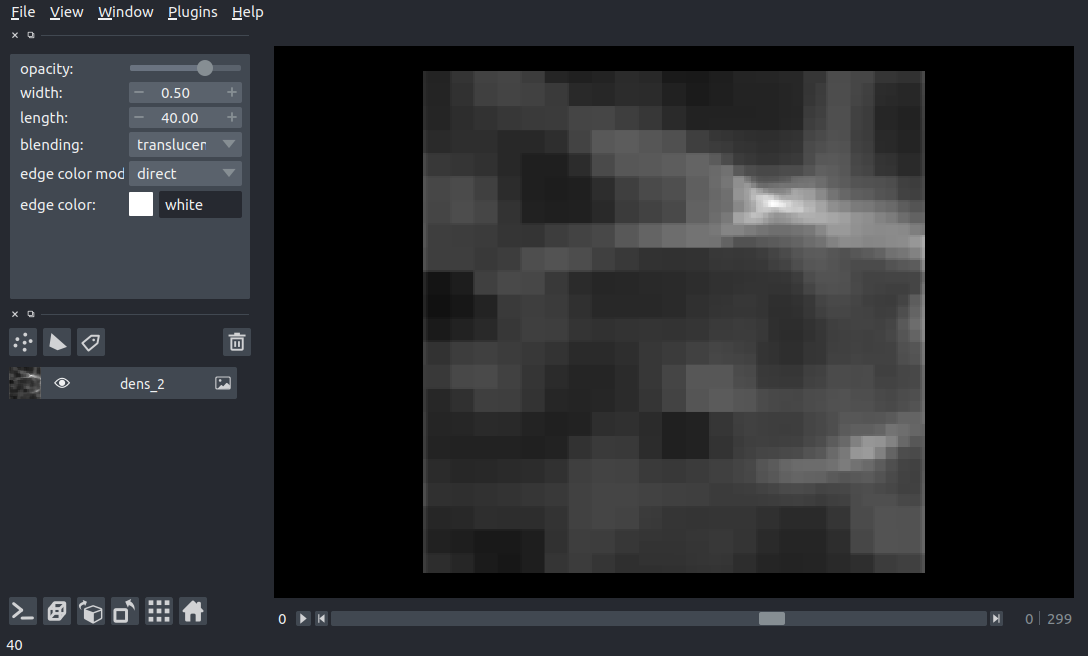

In [257]:
viewer.add_vectors(
        particle_vectors, edge_width=0.5, name='velocity vectors', edge_color='white'
    )
viewer.active_layer.length=40
nbscreenshot(viewer)